In [36]:
import Pkg
Pkg.add("JuMP")

  Resolving package versions...
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Manifest.toml`


In [18]:
Pkg.add("DelimitedFiles")

  Resolving package versions...
Updating `C:\Users\aebou\.julia\environments\v1.5\Project.toml`
  [8bb1440f] + DelimitedFiles
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Manifest.toml`


In [37]:
using NBInclude
using JuMP
using Gurobi
using DelimitedFiles
const GUROBI_ENV = Gurobi.Env()
const L = 6

Academic license - for non-commercial use only - expires 2021-06-28


6

  Resolving package versions...
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\aebou\.julia\environments\v1.5\Manifest.toml`


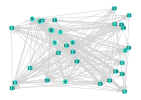

In [31]:
@nbinclude("dataparser.ipynb")

In [45]:
#FONCTIONS A AJOUTER

# Recuperation des arcs
function getEdge(kep)
    edge_list = Array{Array{Int64,1},1}()
    for (ind,arc) in enumerate(edges(kep))
            push!(edge_list,[src(arc), dst(arc)])
    end
    return edge_list
end

getEdge(pool)

#Recuperation de tous les chemins de longueur L+1
function getPath_L(pool)
    all_path = simplecycles_hawick_james(pool) #Recuperation de tous les chemins du graphe
    path_L=[]
    L=6
    for i in all_path #Recuperation des chemins de longueur L+1 dans path_L
        if length(i) == L+1
            push!(path_L, i)
        end
    end
    return path_L
end

getPath_L (generic function with 1 method)

In [50]:
# Le probleme

# Le modèle : choisir un des 2 selon votre ORDI
#model = Model()

model=Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV)))
set_optimizer_attribute(model, "OutputFlag", 0) #???? parametre a modifier

# Le solver
#statut = set_optimizer(model, GLPK.Optimizer)

# Les donnees
path_L = getPath_L(pool)

#Ensemble des arcs sous la forme [i,j]
edge_list = getEdge(pool); #Penser a ajouter la fonction PROBLEME_SANS_REFORMULATION

#Nombre de sommets
E = ne(pool)
V = nv(pool)

#Les variables
@variable(model, x[i in 1:E, j in 1:E], Bin)

#La fonction objective
@objective(model, Max, sum(x[e[1],e[2]] for e in 1:E))

#les contraintes
#Premiere contrainte
for i in 1:V
    E_1 = [] #Ensemble des arcs ou i est le depart
    E_2 = [] #Ensemble des arcs ou i est l arrivee
    #Recuperer les arcs ou il y a i en extremite
    for e in edge_list
        if e[1] == i
            push!(E_1, e[2])
        end
        if e[2] == i
            push!(E_2, e[1])
        end
    end
    #La contrainte sur le sommet i
    @constraint(model, sum(x[e, i] for e in E_2) == sum(x[i, e for e in E_1)))
end

#Deuxieme contrainte
for i in 1:V
    E_i = [] #Ensemble des arcs ou i est l arrivee
    #Recuperer les arcs ou il y a i en extremite
    for e in 1:E
        if e[1] == i
            push!(E_i, e[2])
        end
    end
    #La contrainte sur le sommet i
    @constraint(model, sum(x[i, e[2]] for e in 1:E_i) <= 1)
end

#Troisieme contrainte
for p in path_L #Pour tous les chemins de longueur L+1
    @constraint(model, sum(x[p[j], p[j+1]] for j in 1:L) <= L-1)
end

LoadError: BoundsError